In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Expirement 5 using ELA

In [0]:
import os

from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
!wget 'https://fyp-content-bucket.s3.amazonaws.com/CASIA_ELA.zip.7z'

--2019-12-12 13:40:35--  https://fyp-content-bucket.s3.amazonaws.com/CASIA_ELA.zip.7z
Resolving fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)... 52.216.165.19
Connecting to fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)|52.216.165.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1375594296 (1.3G) [application/x-7z-compressed]
Saving to: ‘CASIA_ELA.zip.7z’

CASIA_ELA.zip.7z    100%[===================>]   1.28G  15.4MB/s    in 73s     

2019-12-12 13:41:48 (18.1 MB/s) - ‘CASIA_ELA.zip.7z’ saved [1375594296/1375594296]



In [0]:
!7z e CASIA_ELA.zip.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1375594296 bytes (1312 MiB)

Extracting archive: CASIA_ELA.zip.7z
--
Path = CASIA_ELA.zip.7z
Type = 7z
Physical Size = 1375594296
Headers Size = 130
Method = LZMA2:26
Solid = -
Blocks = 1

  0%      3% - CASIA_ELA.zip                      6% - CASIA_ELA.zip                      9% - CASIA_ELA.zip                     12% - CASIA_ELA.zip                     15% - CASIA_ELA.zip                     18% - CASIA_ELA.zip                     23% - CASIA_ELA.zip

In [0]:
!unzip CASIA_ELA.zip

Archive:  CASIA_ELA.zip
   creating: CASIA_ELA/
   creating: CASIA_ELA/Valid/
  inflating: CASIA_ELA/.DS_Store     
  inflating: __MACOSX/CASIA_ELA/._.DS_Store  
   creating: CASIA_ELA/Test/
   creating: CASIA_ELA/Train/
   creating: CASIA_ELA/Valid/Tampered/
   creating: CASIA_ELA/Valid/Authentic/
   creating: CASIA_ELA/Test/Tampered/
  inflating: CASIA_ELA/Test/.DS_Store  
  inflating: __MACOSX/CASIA_ELA/Test/._.DS_Store  
   creating: CASIA_ELA/Test/Authentic/
   creating: CASIA_ELA/Train/Tampered/
  inflating: CASIA_ELA/Train/.DS_Store  
  inflating: __MACOSX/CASIA_ELA/Train/._.DS_Store  
   creating: CASIA_ELA/Train/Authentic/
  inflating: CASIA_ELA/Valid/Tampered/Tp_S_CNN_S_N_arc00041_arc00041_01084.ela.png  
  inflating: CASIA_ELA/Valid/Tampered/Tp_S_CRN_S_N_nat00098_nat00098_10063.ela.png  
  inflating: CASIA_ELA/Valid/Tampered/Tp_S_NND_S_N_ani00088_ani00088_00208.ela.png  
  inflating: CASIA_ELA/Valid/Tampered/Tp_S_NRN_M_N_arc10125_arc10125_11887.ela.png  
  inflating: CASIA_E

In [0]:
path = Path("/root/.fastai/data/CASIA_ELA"); path

PosixPath('/root/.fastai/data/CASIA_ELA')

In [0]:
path_to_test = Path("/root/.fastai/data/Test")
test = ImageList.from_folder(path_to_test)

In [0]:
tfms = get_transforms([*rand_pad(padding=3, size=28, mode='reflection')], [])
size = (256, 384)

In [0]:
src = (ImageList.from_folder(path)
                         .split_by_folder(train='Train', valid='Valid')
                         .label_from_folder())

In [0]:
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=64, num_workers=4).normalize(imagenet_stats)

Tampered


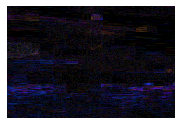

In [0]:
x,y = data.train_ds[61]
x.show()
print(y)

In [0]:
x.shape

torch.Size([3, 256, 384])

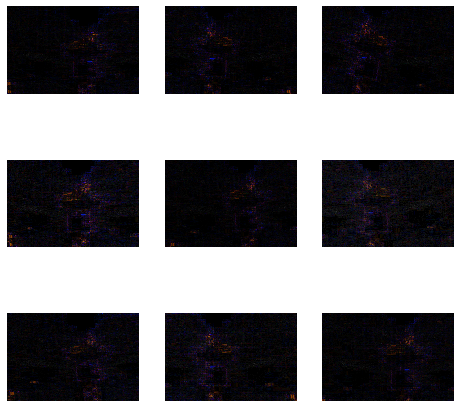

In [0]:
def _plot(i,j,ax): data.train_ds[45][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 256, 384]), torch.Size([64]))

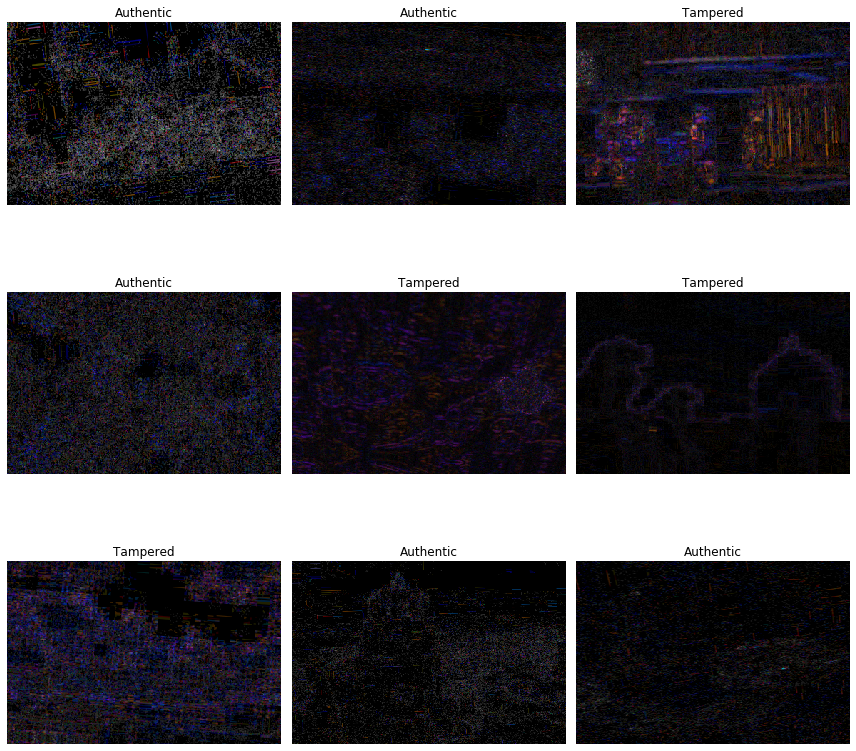

In [0]:
data.show_batch(rows=3, figsize=(12,12))

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 48.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


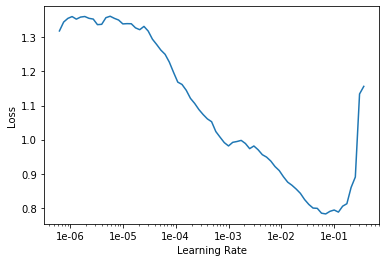

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-02

In [0]:
learn.fit_one_cycle(35, lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.395178,0.274510,0.115301,04:42
1,0.274804,0.219268,0.101850,04:28
2,0.218318,0.251902,0.115542,04:29
3,0.199070,0.189415,0.089359,04:31
4,0.199326,0.241014,0.119385,04:30
5,0.182300,0.314657,0.088638,04:30
6,0.192971,0.254406,0.089839,04:30
7,0.185228,0.255149,0.095844,04:29
8,0.192660,0.206630,0.081912,04:29
9,0.178340,0.373152,0.161662,04:30


In [0]:
learn.save('ela-exp5-attempt-1-resnet50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


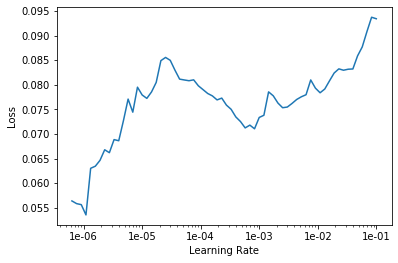

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('Tampered', 'Authentic', 120), ('Authentic', 'Tampered', 97)]

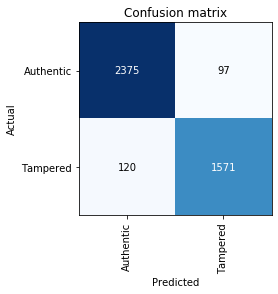

In [0]:
interp.plot_confusion_matrix()

In [0]:
learn.export()

In [0]:
!wget 'https://fyp-content-bucket.s3.amazonaws.com/export.pkl'

In [0]:
learn = load_learner(path)

In [0]:
path = '/content/data/Test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)
    
            if conf >=65:
                print('Predicted: {} ------ Confidence: {:.3f}% ------ Actual: {}'.format(pred_class, conf, folder))
            
            

/content/data/Test/Tampered/
Predicted: Tampered ------ Confidence: 99.990% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 99.962% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 99.999% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 100.000% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 83.724% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 99.997% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 89.202% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 80.486% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 95.611% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 99.999% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 99.815% ------ Actual: Tampered
Predicted: Authentic ------ Confidence: 84.560% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 100.000% ------ Actual: Tampered
Predicted: Tampered ------ Confidence: 73.826

In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [0]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_fake/total_fake) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
481/502. Accuracy = 92.73%
Images Classified As Tampered
319/344. Accuracy = 92.73%


In [0]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 96.853%
